In [1]:
import os
import zipfile
import urllib

import numpy as np
import pandas as pd
import geopandas as gpd
import shapely
from fiona.crs import from_epsg

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.ensemble  import RandomForestClassifier as rfc
#from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

import pylab as pl
import matplotlib.pylab as plt
from IPython.display import Image
from IPython.display import clear_output
pl.rcParams['font.size'] = 20
%pylab inline
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Uber & Lyft (from FHV)

In [2]:
UberLyft = pd.read_csv("output_UberLyft/UberLyft.csv")
nrow_UberLyft = UberLyft.shape[0]
print(UberLyft.shape)
UberLyft.head()

(11519915, 4)


date  PUlocationID  DOlocationID  count
0  2015-01-01           113             0    715
1  2015-01-01           144             0    941
2  2015-01-01           141             0    514
3  2015-01-01            79             0   2023
4  2015-01-01           246             0    820

In [3]:
UberLyft.tail()

date  PUlocationID  DOlocationID  count
11519910  2018-06-27           160             1      1
11519911  2018-06-30           250            89      1
11519912  2018-06-26            85           117      1
11519913  2018-06-27            33           135      1
11519914  2018-06-25           175           177      1

## outlier delete: done when cleaning with spark

## time series analysis

### time stamp conversion

In [4]:
UberLyft["date"] = pd.to_datetime(UberLyft["date"],format='%Y-%m-%d')
print(type(UberLyft["date"][0]))
UberLyft["date"][0]

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


Timestamp('2015-01-01 00:00:00')

In [5]:
dates = UberLyft[['date']].drop_duplicates().sort_values(by='date').reset_index(drop=True)
print(dates.shape)
dates.head()

(1277, 1)


date
0 2015-01-01
1 2015-01-02
2 2015-01-03
3 2015-01-04
4 2015-01-05

In [6]:
dates.tail()

date
1272 2018-06-26
1273 2018-06-27
1274 2018-06-28
1275 2018-06-29
1276 2018-06-30

### daily overall activities

In [7]:
UberLyft_daily = UberLyft.groupby('date').sum()[['count']].sort_index()
UberLyft_daily.head()

count
date             
2015-01-01  48715
2015-01-02  33877
2015-01-03  50228
2015-01-04  34961
2015-01-05  36290

In [8]:
UberLyft_daily.shape[0]

1277

Text(0.5, 1.0, 'time series for the number of daily UberLyft activities')

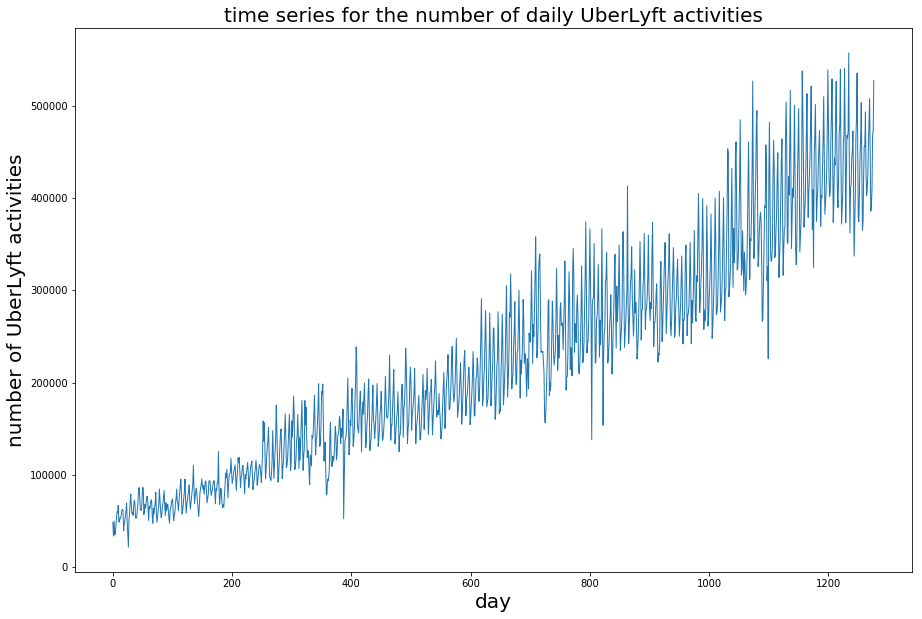

In [9]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.plot(range(UberLyft_daily.shape[0]), UberLyft_daily['count'], '-', linewidth=1)
ax.set_ylabel('number of UberLyft activities', fontsize=20)
ax.set_xlabel('day', fontsize=20)
ax.set_title('time series for the number of daily UberLyft activities', fontsize=20)

### daily pickup

In [10]:
# daily sum
UberLyft_pickup = UberLyft.groupby(['date', 'PUlocationID']).sum()\
                .sort_index().reset_index()[['date', 'PUlocationID', 'count']]
print(UberLyft_pickup.shape)
UberLyft_pickup.head()

(325562, 3)


date  PUlocationID  count
0 2015-01-01             0     28
1 2015-01-01             1      1
2 2015-01-01             3      9
3 2015-01-01             4    411
4 2015-01-01             6      2

In [11]:
# daily mean
UberLyft_pickup_mean = UberLyft_pickup.groupby(['date']).mean()\
                .reset_index()[['date', 'count']]
print(UberLyft_pickup_mean.shape)
UberLyft_pickup_mean.head()

(1277, 2)


date       count
0 2015-01-01  196.431452
1 2015-01-02  142.340336
2 2015-01-03  207.553719
3 2015-01-04  144.466942
4 2015-01-05  150.580913

Wall time: 2.19 s


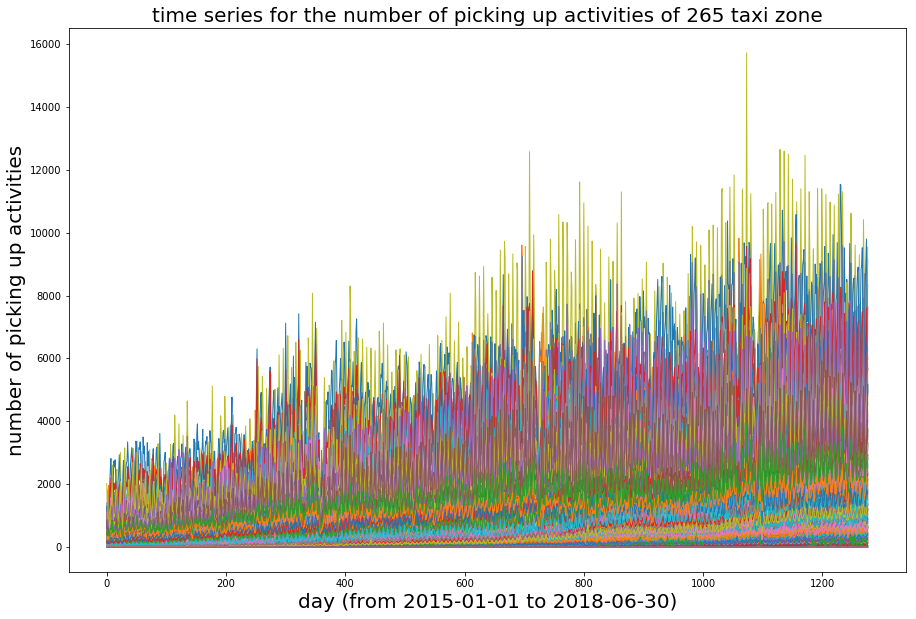

In [12]:
%%time
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
for i in range(1,266):    
    num_days = len(UberLyft_pickup['date'].unique())    
    count_deficient = UberLyft_pickup[UberLyft_pickup['PUlocationID']==i]
    count = pd.merge(dates,count_deficient, on='date', how='outer').fillna(0)['count']
    ax.plot(range(num_days), count, '-', linewidth=1)
ax.set_ylabel('number of picking up activities', fontsize=20)
ax.set_xlabel('day (from 2015-01-01 to 2018-06-30)', fontsize=20)
ax.set_title('time series for the number of picking up activities of 265 taxi zone', fontsize=20)

Wall time: 1.97 s


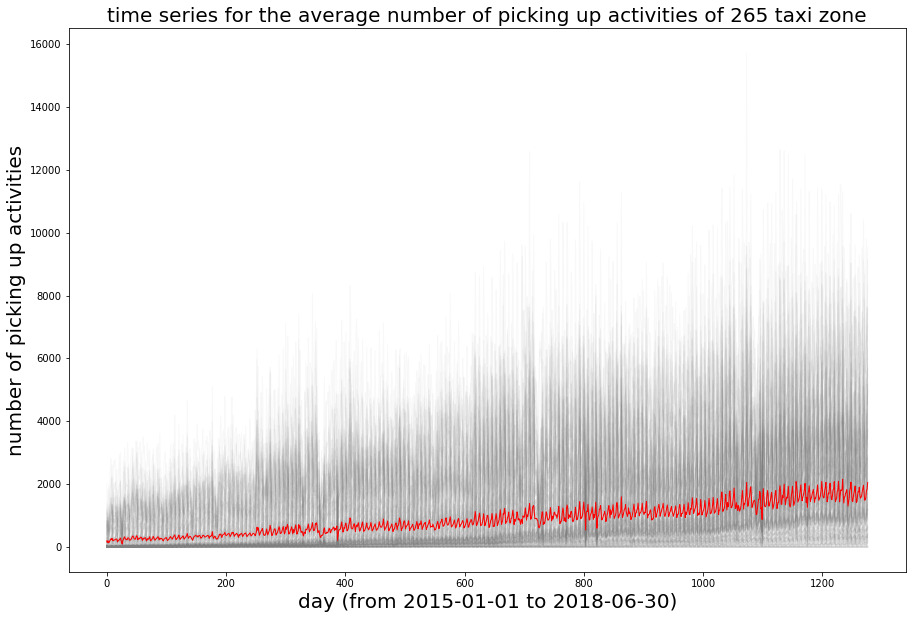

In [13]:
%%time
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
for i in range(1,266):    
    num_days = len(UberLyft_pickup['date'].unique())    
    count_deficient = UberLyft_pickup[UberLyft_pickup['PUlocationID']==i]
    count = pd.merge(dates,count_deficient, on='date', how='outer').fillna(0)['count']
    ax.plot(range(num_days), count, '-', linewidth=1, alpha=0.05, color='grey')
ax.plot(range(num_days), UberLyft_pickup_mean['count'], '-', linewidth=1, alpha=1, color='r')
ax.set_ylabel('number of picking up activities', fontsize=20)
ax.set_xlabel('day (from 2015-01-01 to 2018-06-30)', fontsize=20)
ax.set_title('time series for the average number of picking up activities of 265 taxi zone', fontsize=20)

### daily dropoff

In [14]:
UberLyft_dropoff = UberLyft.groupby(['date', 'DOlocationID']).sum()\
                .sort_index().reset_index()[['date', 'DOlocationID', 'count']]
print(UberLyft_dropoff.shape)
UberLyft_dropoff.head()

(103236, 3)


date  DOlocationID  count
0 2015-01-01             0  48715
1 2015-01-02             0  33877
2 2015-01-03             0  50228
3 2015-01-04             0  34961
4 2015-01-05             0  36290

In [15]:
UberLyft_dropoff.tail()

date  DOlocationID  count
103231 2018-06-30           259   1363
103232 2018-06-30           260   2467
103233 2018-06-30           261   1766
103234 2018-06-30           262   1520
103235 2018-06-30           263   2684

In [16]:
UberLyft_dropoff_mean = UberLyft_dropoff[UberLyft_dropoff['DOlocationID']!=0].groupby(['date']).mean()\
                .reset_index()[['date', 'count']]
UberLyft_dropoff_mean = pd.merge(dates, UberLyft_dropoff_mean, on='date', how='left').fillna(0)
print(UberLyft_dropoff_mean.shape)
UberLyft_dropoff_mean.head()

(1277, 2)


date  count
0 2015-01-01    0.0
1 2015-01-02    0.0
2 2015-01-03    0.0
3 2015-01-04    0.0
4 2015-01-05    0.0

UberLyft_dropoff_mean = UberLyft_dropoff.groupby(['date']).mean()\
                .reset_index()[['date', 'count']]
UberLyft_dropoff_mean = pd.merge(dates, UberLyft_dropoff_mean, on='date', how='left').fillna(0)
print(UberLyft_dropoff_mean.shape)
UberLyft_dropoff_mean.head()

Wall time: 1.4 s


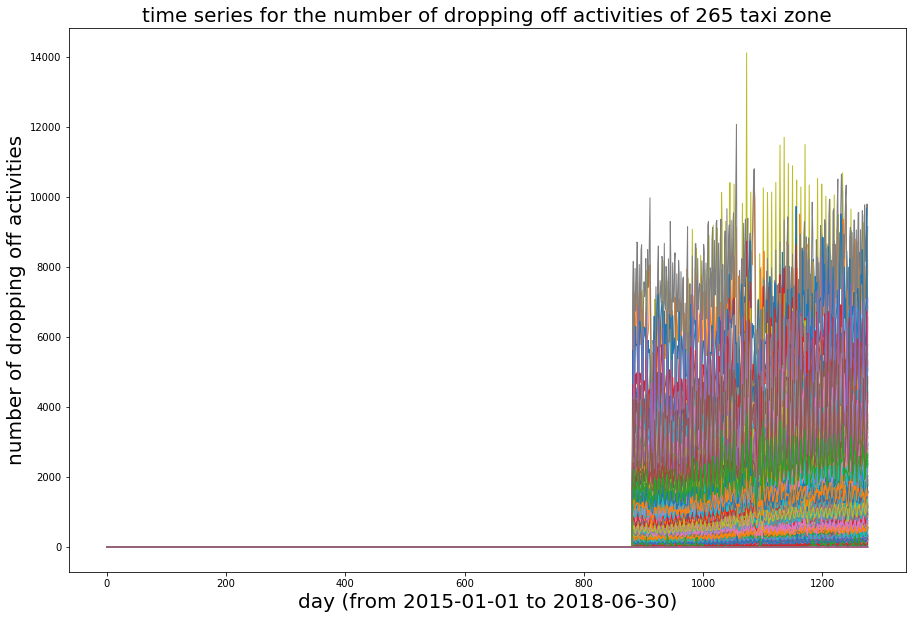

In [17]:
%%time
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
for i in range(1,266):    
    num_days = len(UberLyft_dropoff['date'].unique())    
    count_deficient = UberLyft_dropoff[UberLyft_dropoff['DOlocationID']==i]
    count = pd.merge(dates,count_deficient, on='date', how='outer').fillna(0)['count']
    ax.plot(range(num_days), count, '-', linewidth=1)
ax.set_ylabel('number of dropping off activities', fontsize=20)
ax.set_xlabel('day (from 2015-01-01 to 2018-06-30)', fontsize=20)
ax.set_title('time series for the number of dropping off activities of 265 taxi zone', fontsize=20)

Wall time: 1.44 s


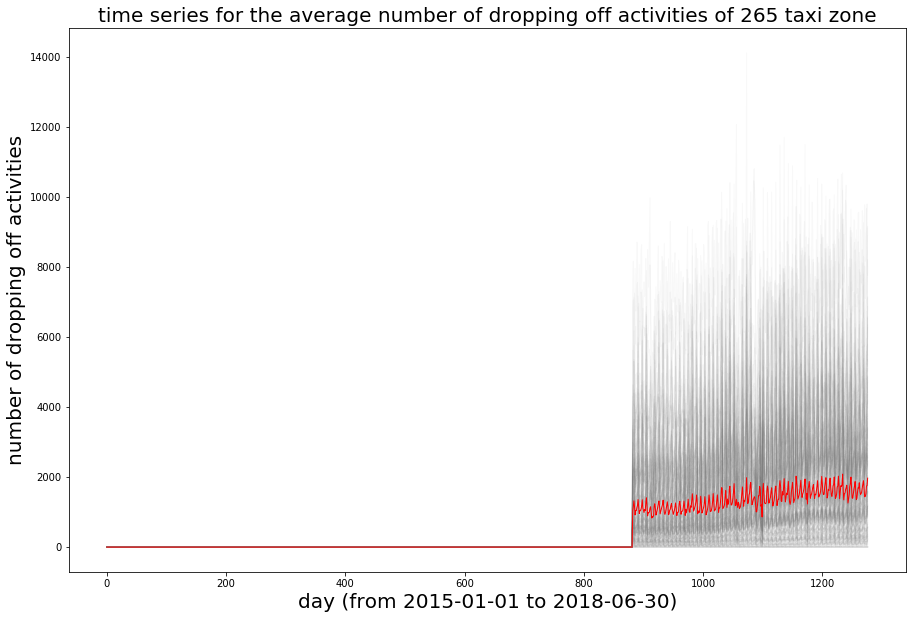

In [18]:
%%time
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
for i in range(1,266):    
    num_days = len(UberLyft_dropoff['date'].unique())    
    count_deficient = UberLyft_dropoff[UberLyft_dropoff['DOlocationID']==i]
    count = pd.merge(dates,count_deficient, on='date', how='outer').fillna(0)['count']
    ax.plot(range(num_days), count, '-', linewidth=1, alpha=0.05, color='grey')

ax.plot(range(num_days), UberLyft_dropoff_mean['count'], '-', linewidth=1, alpha=1, color='r')

ax.set_ylabel('number of dropping off activities', fontsize=20)
ax.set_xlabel('day (from 2015-01-01 to 2018-06-30)', fontsize=20)
ax.set_title('time series for the average number of dropping off activities of 265 taxi zone', fontsize=20)

### outlier detection

**The mean and stardand deviation of the time series can be used to set a 3-sigma threshold**  
**every value that is more then 3 sigmas away from the mean can be flagged as an event**

In [19]:
outlier = UberLyft_dropoff[UberLyft_dropoff['date']==UberLyft_dropoff['date'][len(UberLyft_dropoff)-1]]
outlier = outlier[outlier['count']== outlier['count'].max()]
DOlocationID_outlier = int(outlier['DOlocationID'])
print("The DOlocationID_outlier is:", DOlocationID_outlier)

The DOlocationID_outlier is: 0


## taxi zones geometry

In [20]:
if not os.path.isfile("taxi_zones/taxi_zones.shp"):    
    !curl https://s3.amazonaws.com/nyc-tlc/misc/taxi_zones.zip > taxi_zones.zip
    !mv taxi_zones.zip taxi_zones
    !unzip -o taxi_zones/taxi_zones.zip -d taxi_zones
else:
    print("file in place, you can continue")

taxi_zones = gpd.read_file("taxi_zones/taxi_zones.shp")
# taxi_zones.plot()

file in place, you can continue


In [21]:
print(taxi_zones.shape)
taxi_zones.head()

(263, 7)


OBJECTID  Shape_Leng  Shape_Area                     zone  LocationID  \
0         1    0.116357    0.000782           Newark Airport           1   
1         2    0.433470    0.004866              Jamaica Bay           2   
2         3    0.084341    0.000314  Allerton/Pelham Gardens           3   
3         4    0.043567    0.000112            Alphabet City           4   
4         5    0.092146    0.000498            Arden Heights           5   

         borough                                           geometry  
0            EWR  POLYGON ((933100.9183527103 192536.0856972019,...  
1         Queens  (POLYGON ((1033269.243591294 172126.0078125, 1...  
2          Bronx  POLYGON ((1026308.769506663 256767.6975403726,...  
3      Manhattan  POLYGON ((992073.4667968601 203714.0759887695,...  
4  Staten Island  POLYGON ((935843.3104932606 144283.335850656, ...

http://geopandas.org/reference.html  
legend_kwds : dict (default None)  
Keyword arguments to pass to ax.legend()

### overall

### pick up

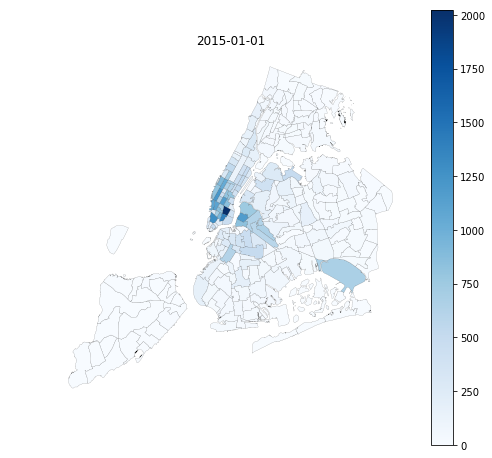

In [22]:
# plot the choropleth of the first day
date = dates['date'][0]
UberLyft_pickup_plot = UberLyft_pickup[UberLyft_pickup['date']==date]
taxi_zones_plot = pd.merge(taxi_zones, UberLyft_pickup_plot, left_on = 'LocationID', right_on = 'PUlocationID', how='left')

fig, ax = plt.subplots(figsize=(8, 8))
taxi_zones_plot.fillna(0).plot(column = 'count', cmap='Blues', linewidth=0.1, ax=ax, edgecolor='black', legend=True)
ax.set_axis_off()
plt.title(str(date)[:10])

fig.savefig('png_pickup/'+str(date)[:10])


#### GIF
%%time
for i in dates['date']:
    date = i
    UberLyft_pickup_plot = UberLyft_pickup[UberLyft_pickup['date']==date]
    taxi_zones_plot = pd.merge(taxi_zones, UberLyft_pickup_plot, left_on = 'LocationID', right_on = 'PUlocationID', how='left')

    fig, ax = plt.subplots(figsize=(8, 8))
    taxi_zones_plot.fillna(0).plot(column = 'count', cmap='Blues', linewidth=0.1, ax=ax, edgecolor='black', legend=True)
    ax.set_axis_off()
    plt.title(str(date)[:10])

    fig.savefig('png_pickup/'+str(date)[:10])

### drop off

# Tickets

## time series analysis

### time stamp conversion

In [23]:
tickets = pd.read_csv("output_tickets_zone_filterType/tickets_zone_filterType.csv")
print(tickets.shape)
tickets.head()

(561439, 3)


date  zone  count
0  08/13/2000    60      1
1  08/18/2000   135      1
2  10/02/2000   141      1
3  10/04/2000   165      1
4  10/15/2000   248      1

In [24]:
tickets["date"] = pd.to_datetime(tickets["date"],format='%m/%d/%Y')
tickets = tickets.sort_values(by = 'date')

tickets = tickets[tickets['date'].isin(dates['date'])]

# data from different year may contains the row of the same date 
tickets = tickets.groupby(['date','zone']).sum().reset_index()

print(tickets.shape)
tickets.head()

(315579, 3)


date  zone  count
0 2015-01-01     1     10
1 2015-01-01     2     75
2 2015-01-01     4     43
3 2015-01-01     5      6
4 2015-01-01     6     22

In [25]:
tickets.tail()

date  zone  count
315574 2018-06-30   258     48
315575 2018-06-30   259     62
315576 2018-06-30   260      9
315577 2018-06-30   261      4
315578 2018-06-30   262    146

### daily overall tickets

In [26]:
# daily sum
tickets_daily = tickets.groupby('date').sum().reset_index()
print(tickets_daily.shape)
tickets_daily.head()

(1277, 3)


date   zone  count
0 2015-01-01  26530   5375
1 2015-01-02  32386  47233
2 2015-01-03  31237  23933
3 2015-01-04  27321   6651
4 2015-01-05  32888  46178

In [27]:
# daily mean
tickets_mean = tickets.groupby(['date']).mean()\
                .reset_index()[['date', 'count']]
print(tickets_mean.shape)
tickets_mean.head()

(1277, 2)


date       count
0 2015-01-01   27.146465
1 2015-01-02  193.577869
2 2015-01-03  100.983122
3 2015-01-04   32.130435
4 2015-01-05  186.201613

Text(0.5, 1.0, 'time series for the number of daily parking tickets')

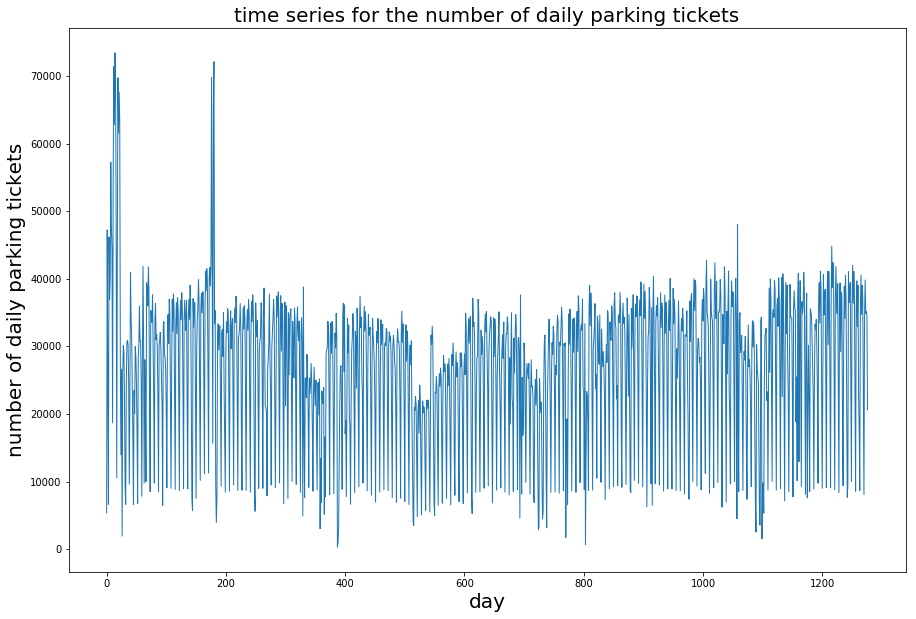

In [28]:
# daily sum plot
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
num_days = len(tickets_daily['date'].unique())
ax.plot(range(num_days), tickets_daily['count'], '-', linewidth=1)
ax.set_ylabel('number of daily parking tickets', fontsize=20)
ax.set_xlabel('day', fontsize=20)
ax.set_title('time series for the number of daily parking tickets', fontsize=20)

### every taxi zone

Wall time: 1.25 s


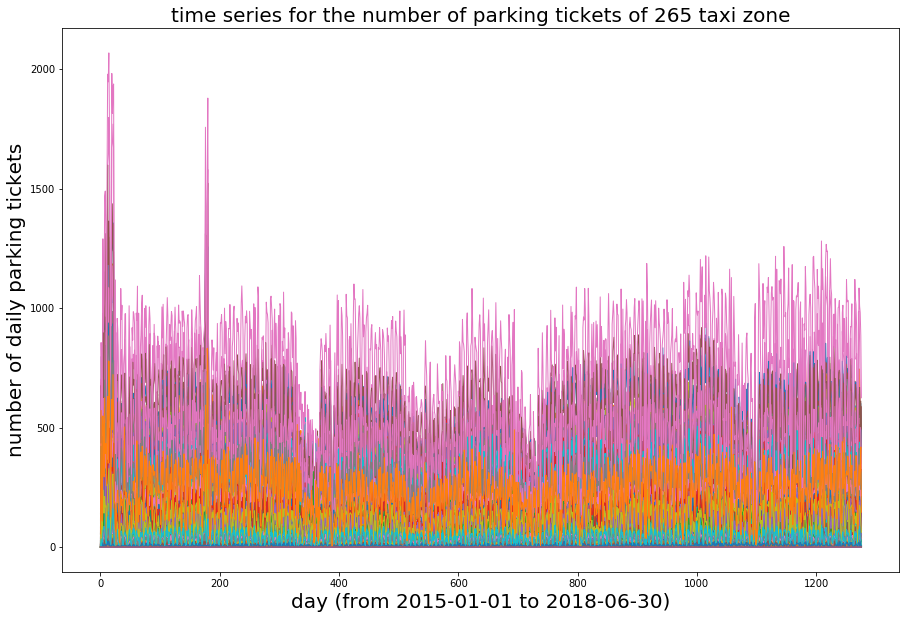

In [29]:
%%time
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)

num_days = len(dates['date'].unique()) 
for i in range(1,266):   
    count_deficient = tickets[tickets['zone']==i]
    count = pd.merge(dates,count_deficient, on='date', how='left').fillna(0)['count']
    ax.plot(range(num_days), count, '-', linewidth=1)
ax.set_ylabel('number of daily parking tickets', fontsize=20)
ax.set_xlabel('day (from 2015-01-01 to 2018-06-30)', fontsize=20)
ax.set_title('time series for the number of parking tickets of 265 taxi zone', fontsize=20)

Wall time: 1.21 s


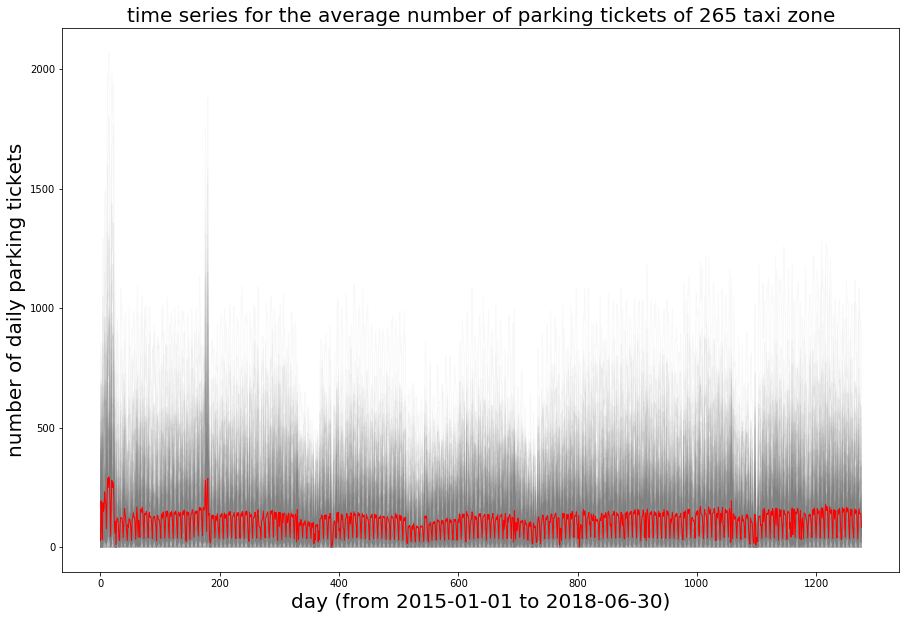

In [30]:
%%time
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)

num_days = len(dates['date'].unique()) 
for i in range(1,266):   
    count_deficient = tickets[tickets['zone']==i]
    count = pd.merge(dates,count_deficient, on='date', how='left').fillna(0)['count']
    ax.plot(range(num_days), count, '-', linewidth=1, alpha=0.05, color='grey')
tickets_mean_reduced = pd.merge(dates,tickets_mean, on='date', how='left')
ax.plot(range(num_days), tickets_mean_reduced['count'], '-', linewidth=1, alpha=1, color='r')
ax.set_ylabel('number of daily parking tickets', fontsize=20)
ax.set_xlabel('day (from 2015-01-01 to 2018-06-30)', fontsize=20)
ax.set_title('time series for the average number of parking tickets of 265 taxi zone', fontsize=20)

## ticket type selecting

In [31]:
tickets_type = pd.read_csv('output_tickets_type/tickets_type.csv')
tickets_type = tickets_type.groupby(['date','type']).sum().reset_index()
tickets_type["date"] = pd.to_datetime(tickets_type["date"],format='%m/%d/%Y')
tickets_type = tickets_type[tickets_type['date'].isin(dates['date'])]
tickets_type = tickets_type.sort_values(by = 'date').reset_index(drop=True)
print(tickets_type.shape)
tickets_type.head()

(87489, 3)


date  type  count
0 2015-01-01     7   2422
1 2015-01-01    99      2
2 2015-01-01    84      2
3 2015-01-01    80      2
4 2015-01-01    78      8

Wall time: 605 ms


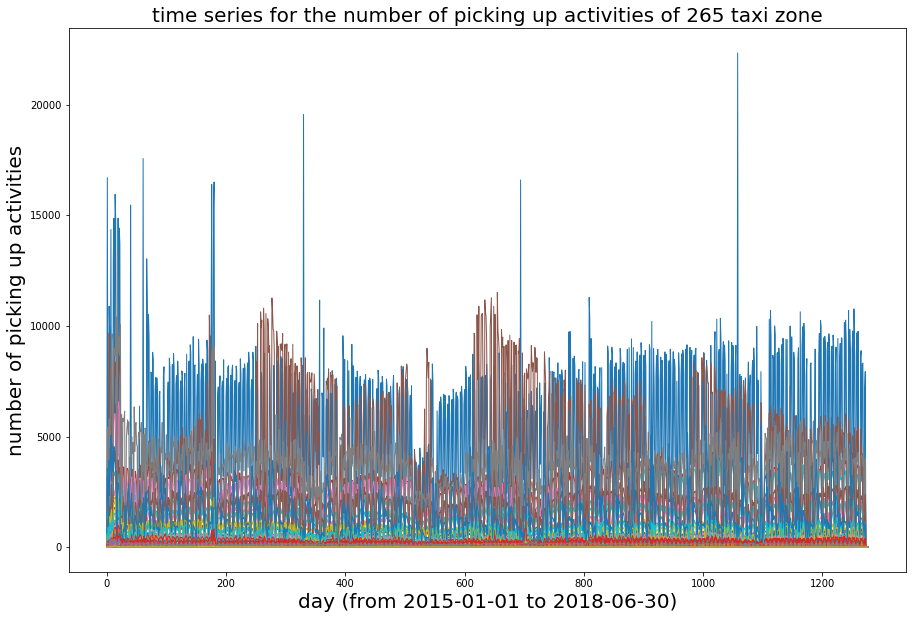

In [32]:
%%time
type_correlation_list = []
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
for i in range(1,100):    
    num_days = len(tickets_type['date'].unique())    
    count_deficient = tickets_type[tickets_type['type']==i]
    count = pd.merge(dates,count_deficient, on='date', how='outer').fillna(0)['count']
    ax.plot(range(num_days), count, '-', linewidth=1)
    type_correlation_list.append(np.corrcoef(count, UberLyft_pickup_mean['count'])[0][1])
ax.set_ylabel('number of picking up activities', fontsize=20)
ax.set_xlabel('day (from 2015-01-01 to 2018-06-30)', fontsize=20)
ax.set_title('time series for the number of picking up activities of 265 taxi zone', fontsize=20)

Wall time: 525 ms


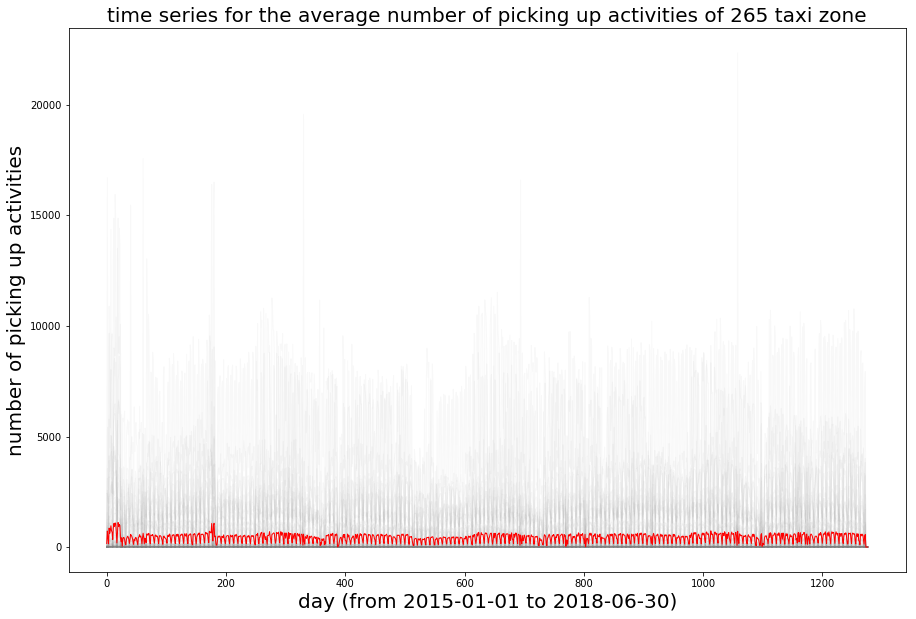

In [33]:
%%time
tickets_type_mean = tickets_type.groupby('date').mean()
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
for i in range(1,100):    
    num_days = len(tickets_type['date'].unique())    
    count_deficient = tickets_type[tickets_type['type']==i]
    count = pd.merge(dates,count_deficient, on='date', how='outer').fillna(0)['count']
    ax.plot(range(num_days), count, '-', linewidth=1, alpha=0.05, color='grey')
ax.plot(range(num_days), tickets_type_mean['count'], '-', linewidth=1, alpha=1, color='r')
ax.set_ylabel('number of picking up activities', fontsize=20)
ax.set_xlabel('day (from 2015-01-01 to 2018-06-30)', fontsize=20)
ax.set_title('time series for the average number of picking up activities of 265 taxi zone', fontsize=20)

In [34]:
tickets_type_dict_df = pd.read_csv('output_tickets_type/ParkingViolationCodes_Nov_2018.csv')
print(tickets_type_dict_df.shape)
tickets_type_dict_df.head()

(97, 4)


VIOLATION CODE           VIOLATION DESCRIPTION  \
0               1   FAILURE TO DISPLAY BUS PERMIT   
1               2  NO OPERATOR NAM/ADD/PH DISPLAY   
2               3  UNAUTHORIZED PASSENGER PICK-UP   
3               4  BUS PARKING IN LOWER MANHATTAN   
4               5              BUS LANE VIOLATION   

   Manhattan  96th St. & below\n(Fine Amount $)  \
0                                           515   
1                                           515   
2                                           515   
3                                           115   
4                                           115   

   All Other Areas\n(Fine Amount $)  
0                               515  
1                               515  
2                               515  
3                               115  
4                               115

In [35]:
from functools import reduce

ticketwords = reduce(lambda x,y: x+y, tickets_type_dict_df['VIOLATION DESCRIPTION'])

import string
ticketwords = ticketwords.lower() # lowercase
translator = str.maketrans(string.punctuation, ' '*len(string.punctuation)) # remove punctuations
ticketwords = ticketwords.translate(translator) # remove punctuations
ticketwords = (list(map(lambda x: x.strip(), ticketwords.split())))

import collections
ticketwords = collections.Counter(ticketwords)
ticketwords = sorted(ticketwords.items(), key=lambda x: x[1], reverse=True)
ticketwords[:5]

[('standing', 15), ('parking', 9), ('comm', 9), ('exc', 7), ('bus', 6)]

In [36]:
type_correlation_df = pd.DataFrame(type_correlation_list).reset_index()
type_correlation_df.columns = ['code', 'correlation']
tickets_type_dict_df = pd.merge(tickets_type_dict_df, type_correlation_df, left_on='VIOLATION CODE', right_on="code").drop(['code'], axis=1).sort_values(by='correlation')

tickets_type_count = tickets_type.groupby('type').sum().sort_values(by='count',ascending=False).reset_index()
tickets_type_dict_df = pd.merge(tickets_type_dict_df, tickets_type_count, left_on='VIOLATION CODE', right_on="type").drop(['type'], axis=1)

In [37]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None): print(tickets_type_dict_df[['VIOLATION CODE', 'VIOLATION DESCRIPTION', 'correlation', 'count']])

    VIOLATION CODE           VIOLATION DESCRIPTION  correlation    count
0               66                DETACHED TRAILER    -0.689522   106184
1               44  PKG IN EXC. OF LIM-COMM MTR ZN    -0.570610      123
2               12      NO STANDING-SNOW EMERGENCY    -0.505738      147
3               38  FAIL TO DSPLY MUNI METER RECPT    -0.482195  4171700
4               93        REMOVE/REPLACE FLAT TIRE    -0.476110       76
5               16  NO STANDING-EXC. TRUCK LOADING    -0.475474   673608
6               90   VEH-SALE/WSHNG/RPRNG/DRIVEWAY    -0.436703      208
7               26   NO STANDING-FOR HIRE VEH STND    -0.413923     4049
8               98            OBSTRUCTING DRIVEWAY    -0.400395   172833
9               82  COMML PLATES-UNALTERED VEHICLE    -0.398241   118026
10              79        UNAUTHORIZED BUS LAYOVER    -0.366101    18680
11              42    EXPIRED MUNI MTR-COMM MTR ZN    -0.352911   259330
12              71   INSP. STICKER-EXPIRED/MISSING 

tickets_type.groupby('type').sum()#.sort_values(by='count',ascending=False)

figure, ax = plt.subplots(figsize=(12 ,10))
ax.hist(tickets_type.groupby('type').sum())

# correlation analysis

## normalize & standardize

reference: https://stackoverflow.com/questions/26414913/normalize-columns-of-pandas-data-frame

from sklearn import preprocessing
def NormalizeDf(df):
    x = df.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df = pandas.DataFrame(x_scaled)
    return df

In [38]:
def normalize(x):
    return(x-x.min())/(x.max()-x.min())

In [39]:
def standardize(time_series):
    return((time_series - mean(time_series)) / std(time_series))

## Merge all datesets

In [40]:
df = pd.merge(UberLyft_pickup, UberLyft_dropoff, left_on = ['date', 'PUlocationID'], right_on=['date', 'DOlocationID'], how='outer')
df['DOlocationID'].fillna(value = df['PUlocationID'], inplace=True)
df['PUlocationID'].fillna(value = df['DOlocationID'], inplace=True)
df.fillna(0, inplace=True)
df = df.drop(['DOlocationID'], axis=1)
df.columns = ['date', 'zone', 'pickup', 'dropoff']
print(df.shape)
df.head()

(326216, 4)


date  zone  pickup  dropoff
0 2015-01-01   0.0    28.0  48715.0
1 2015-01-01   1.0     1.0      0.0
2 2015-01-01   3.0     9.0      0.0
3 2015-01-01   4.0   411.0      0.0
4 2015-01-01   6.0     2.0      0.0

In [41]:
df = pd.merge(df, tickets, left_on = ['date', 'zone'], right_on=['date', 'zone'], how='outer').fillna(0)
df.rename(columns={'count': 'tickets'}, inplace=True)
print(df.shape)
df.head()

(333768, 5)


date  zone  pickup  dropoff  tickets
0 2015-01-01   0.0    28.0  48715.0      0.0
1 2015-01-01   1.0     1.0      0.0     10.0
2 2015-01-01   3.0     9.0      0.0      0.0
3 2015-01-01   4.0   411.0      0.0     43.0
4 2015-01-01   6.0     2.0      0.0     22.0

In [42]:
df.tail()

date   zone  pickup  dropoff  tickets
333763 2018-06-28  199.0     0.0      0.0     37.0
333764 2018-06-29  105.0     0.0      0.0     72.0
333765 2018-06-29  199.0     0.0      0.0     28.0
333766 2018-06-30  105.0     0.0      0.0     14.0
333767 2018-06-30  199.0     0.0      0.0     19.0

In [43]:
%%time
df.to_csv('output_final/data_final.csv', index=False)

Wall time: 2.87 s


df = pd.read_csv('output_final/data_final.csv')

In [44]:
df_standardized = df.copy()
df_standardized['pickup'] = standardize(df['pickup'])
df_standardized['dropoff'] = standardize(df['dropoff'])
df_standardized['tickets'] = standardize(df['tickets'])
df_standardized.describe()

zone        pickup       dropoff       tickets
count  333768.000000  3.337680e+05  3.337680e+05  3.337680e+05
mean      131.769834 -2.892497e-15 -3.411238e-14 -1.835093e-15
std        76.535763  1.000001e+00  1.000001e+00  1.000001e+00
min         0.000000 -7.252051e-01 -9.311174e-02 -7.888022e-01
25%        65.000000 -6.595007e-01 -9.311174e-02 -6.423431e-01
50%       133.000000 -4.241290e-01 -9.311174e-02 -3.494251e-01
75%       198.000000  2.720055e-01 -6.534757e-02  2.518279e-01
max       263.000000  1.234582e+01  4.403622e+01  1.515211e+01

## Correlation exploration

In [45]:
df.corr()

zone    pickup   dropoff   tickets
zone     1.000000  0.095909 -0.079848  0.017477
pickup   0.095909  1.000000  0.051177  0.064006
dropoff -0.079848  0.051177  1.000000 -0.034053
tickets  0.017477  0.064006 -0.034053  1.000000

In [46]:
df_standardized.corr()

zone    pickup   dropoff   tickets
zone     1.000000  0.095909 -0.079848  0.017477
pickup   0.095909  1.000000  0.051177  0.064006
dropoff -0.079848  0.051177  1.000000 -0.034053
tickets  0.017477  0.064006 -0.034053  1.000000

%%time
### correlation matrix: sfig = pd.scatter_matrix(df, s=30, figsize=(10, 10), diagonal='kde')
sfig = pd.plotting.scatter_matrix(df, s=30, figsize=(10, 10), diagonal='kde')

### Time series plot

In [47]:
tickets_daily_reduced = pd.merge(dates,tickets_daily, on='date', how='left')

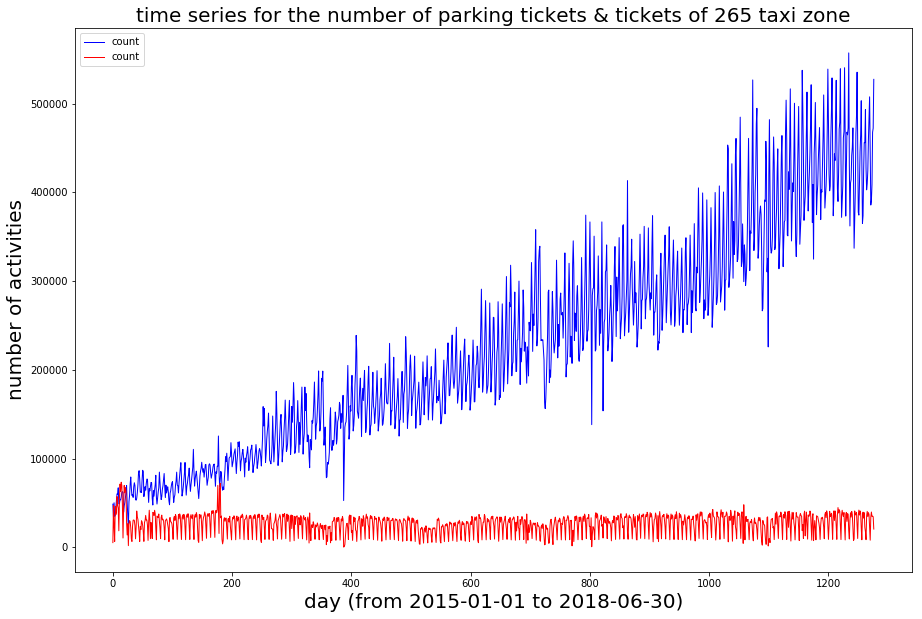

In [48]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.plot(range(UberLyft_daily.shape[0]), UberLyft_daily['count'], '-', linewidth=1, color='b')
ax.plot(range(UberLyft_daily.shape[0]), tickets_daily_reduced['count'], '-', linewidth=1, color='r')

ax.set_ylabel('number of activities', fontsize=20)
ax.set_xlabel('day (from 2015-01-01 to 2018-06-30)', fontsize=20)
ax.set_title('time series for the number of parking tickets & tickets of 265 taxi zone', fontsize=20)
ax.legend()

#### normalize

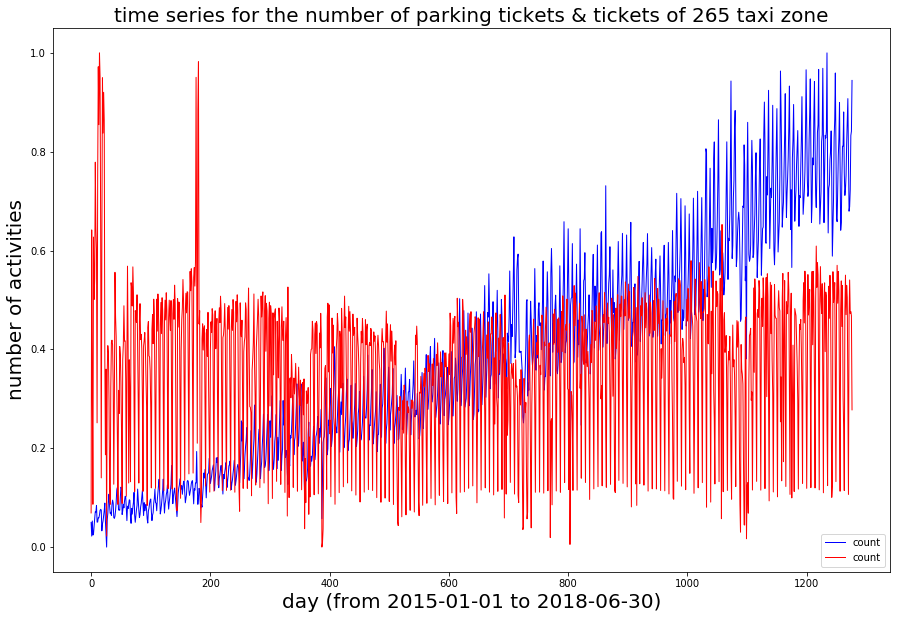

In [49]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.plot(range(UberLyft_daily.shape[0]), normalize(UberLyft_daily['count']), '-', linewidth=1, color='b')
ax.plot(range(UberLyft_daily.shape[0]), normalize(tickets_daily_reduced['count']), '-', linewidth=1, color='r')

ax.set_ylabel('number of activities', fontsize=20)
ax.set_xlabel('day (from 2015-01-01 to 2018-06-30)', fontsize=20)
ax.set_title('time series for the number of parking tickets & tickets of 265 taxi zone', fontsize=20)
ax.legend()

#### standardize

In [50]:
df = df.iloc[:,[0,1,2,4]]

In [51]:
df_daily = df.groupby('date').sum()[['pickup', 'tickets']].sort_index()

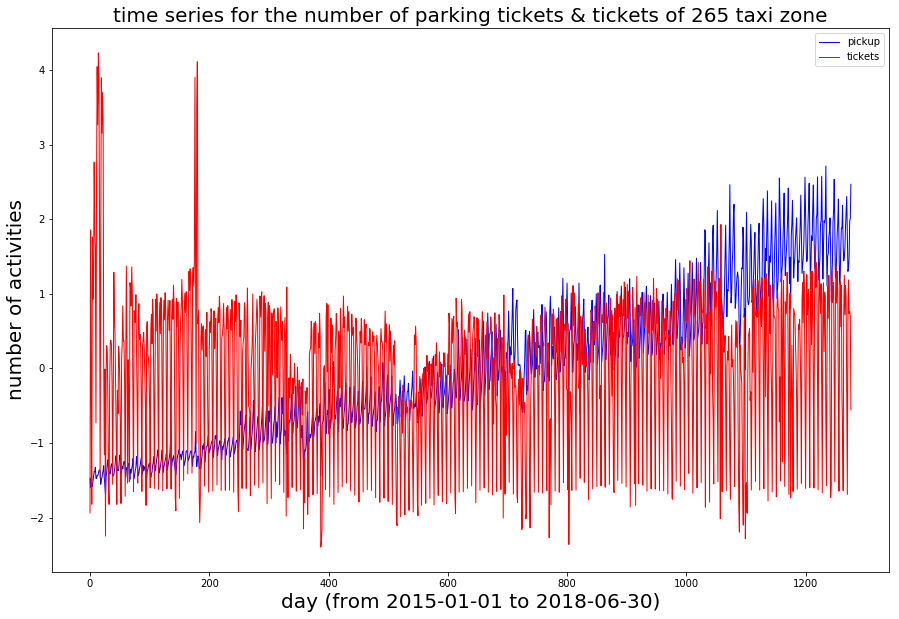

In [52]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.plot(range(UberLyft_daily.shape[0]), standardize(df_daily['pickup']), '-', linewidth=1, color='b')
ax.plot(range(UberLyft_daily.shape[0]), standardize(df_daily['tickets']), '-', linewidth=1, color='r')

ax.set_ylabel('number of activities', fontsize=20)
ax.set_xlabel('day (from 2015-01-01 to 2018-06-30)', fontsize=20)
ax.set_title('time series for the number of parking tickets & tickets of 265 taxi zone', fontsize=20)
ax.legend()

### Hodrick-Prescott (HP) filter
Detect trend and periodicity

**Separate the trends and periodicities and analyze the relationships between the UberLyft and ticket data.**

**Hypothesis: The periodicities of the UberLyft and ticket data are correlated.**

1. $\lambda = 6.25$ for annual data.
2. $\lambda = 129600$ for monthly data.
3. $\lambda = 104976000000$ for daily data.

#### UberLyft pickup

In [53]:
import statsmodels.api as sma

In [54]:
# Decompose into cyclical and trend components.
cycle_pickup, trend_pickup = sma.tsa.filters.hpfilter(df_daily['pickup'], lamb = 129600) # monthly

Text(0, 0.5, '')

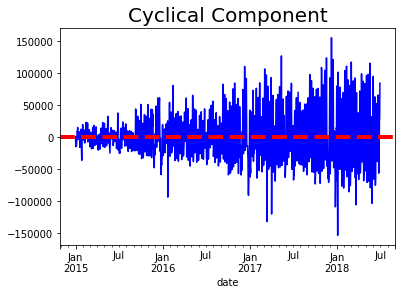

In [55]:
# Cyclical component
cycle_pickup.plot(color='blue')
plt.title('Cyclical Component', fontsize=20)
plt.axhline(0, color='r', ls='--', lw=4)
plt.ylabel('', fontsize=16)

Text(0, 0.5, '')

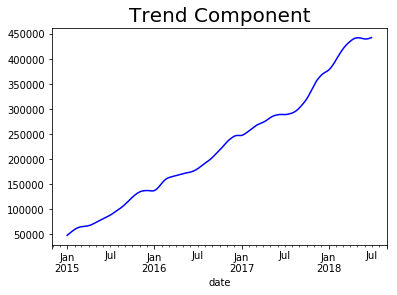

In [56]:
# Trend component.
trend_pickup.plot(color='blue')
plt.title('Trend Component', fontsize=20)
plt.ylabel('', fontsize=16)

Text(0, 0.5, '$\\rho$')

<Figure size 576x432 with 0 Axes>

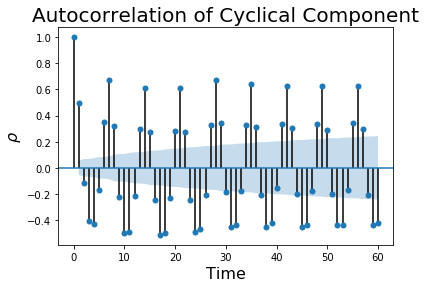

In [57]:
fig = plt.figure(figsize=(8, 6))
fig = sma.graphics.tsa.plot_acf(cycle_pickup.squeeze(), lags=60)
plt.title(r'Autocorrelation of Cyclical Component', fontsize=20)
plt.xlabel('Time', fontsize=16)
plt.ylabel(r'$\rho$', fontsize=16)

#### tickets

In [58]:
# Decompose into cyclical and trend components.
cycle_tickets, trend_tickets = sma.tsa.filters.hpfilter(df_daily['tickets'], lamb = 129600) # monthly

Text(0, 0.5, '')

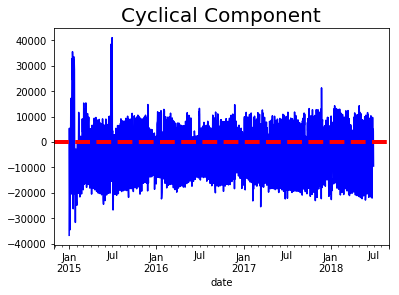

In [59]:
# Cyclical component
cycle_tickets.plot(color='blue')
plt.title('Cyclical Component', fontsize=20)
plt.axhline(0, color='r', ls='--', lw=4)
plt.ylabel('', fontsize=16)

Text(0, 0.5, '')

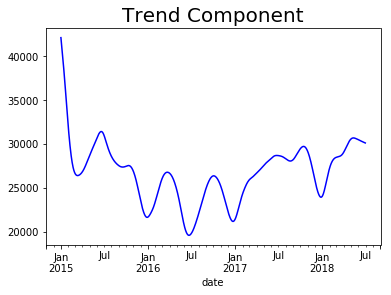

In [60]:
# Trend component.
trend_tickets.plot(color='blue')
plt.title('Trend Component', fontsize=20)
plt.ylabel('', fontsize=16)

Text(0, 0.5, '$\\rho$')

<Figure size 576x432 with 0 Axes>

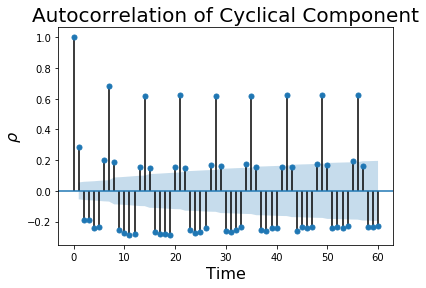

In [61]:
fig = plt.figure(figsize=(8, 6))
fig = sma.graphics.tsa.plot_acf(cycle_tickets.squeeze(), lags=60)
plt.title(r'Autocorrelation of Cyclical Component', fontsize=20)
plt.xlabel('Time', fontsize=16)
plt.ylabel(r'$\rho$', fontsize=16)

In [62]:
print("The correlation of the Cyclical Component is: %f"%(np.corrcoef(cycle_tickets, cycle_pickup)[0][1]))

The correlation of the Cyclical Component is: -0.207711


In [63]:
print("The correlation of the trend Component is: %f"%(np.corrcoef(trend_tickets, trend_pickup)[0][1]))

The correlation of the trend Component is: 0.062370


### 265 pairs of lines for UberLyft pick up and tickets

Wall time: 25.9 ms


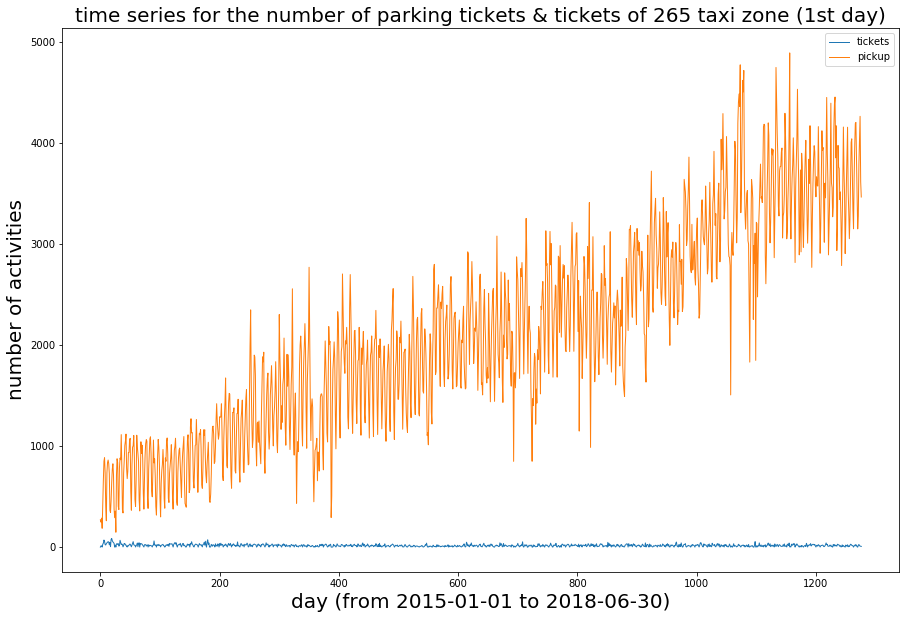

In [64]:
%%time
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)

num_days = len(dates['date'].unique()) 

i=100
temp = pd.merge(dates,df[df['zone']==i], on='date', how='left')
ax.plot(range(num_days), temp['tickets'], '-', linewidth=1)
ax.plot(range(num_days), temp['pickup'], '-', linewidth=1)

ax.set_ylabel('number of activities', fontsize=20)
ax.set_xlabel('day (from 2015-01-01 to 2018-06-30)', fontsize=20)
ax.set_title('time series for the number of parking tickets & tickets of 265 taxi zone (1st day)', fontsize=20)
ax.legend()

Wall time: 1.64 s


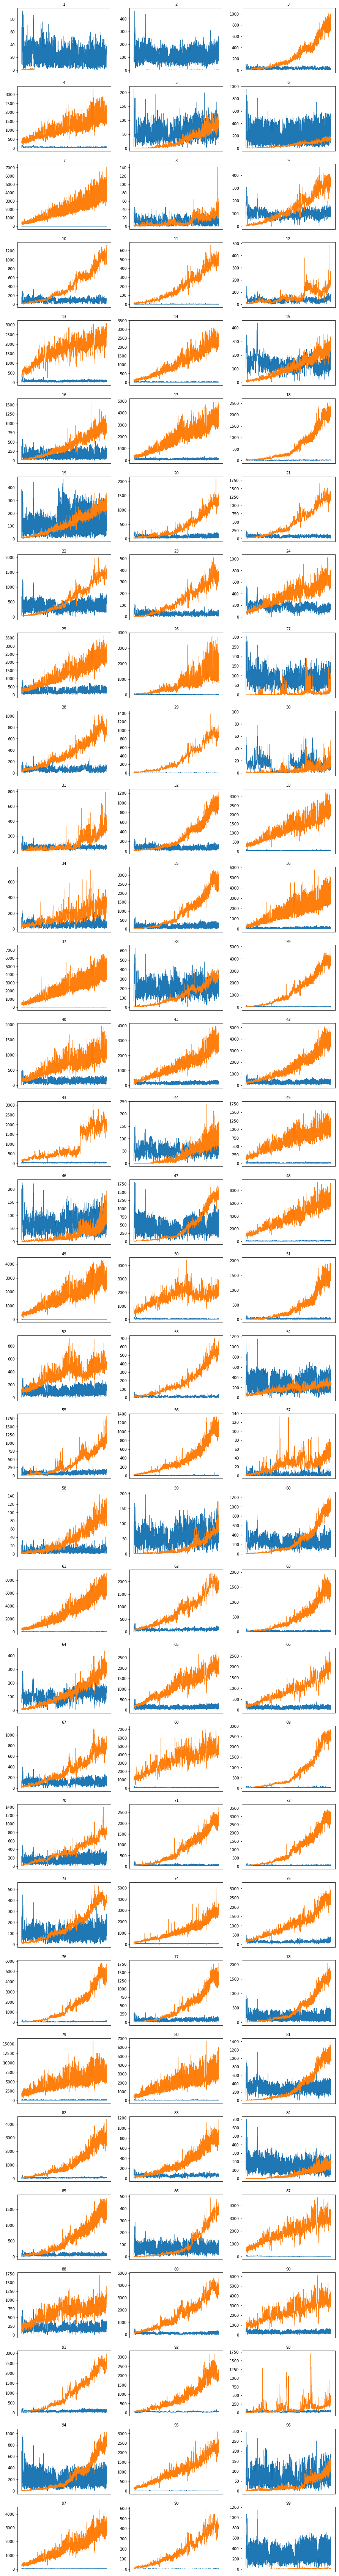

In [65]:
%%time

# Zone 1-99
fig = plt.figure(figsize=(15,200))
num_days = len(dates['date'].unique()) 

for i in range(1,100):
    ax = fig.add_subplot(53,3,i)
    temp = pd.merge(dates, df[df['zone']==i][['date', 'pickup', 'tickets']], how='left')
    ax.plot(range(num_days), temp['tickets'], '-', linewidth=1)
    ax.plot(range(num_days), temp['pickup'], '-', linewidth=1)
    ax.set_title(i, fontsize=10)
    ax.set_xticks([])    
    #ax.legend()

Wall time: 1.59 s


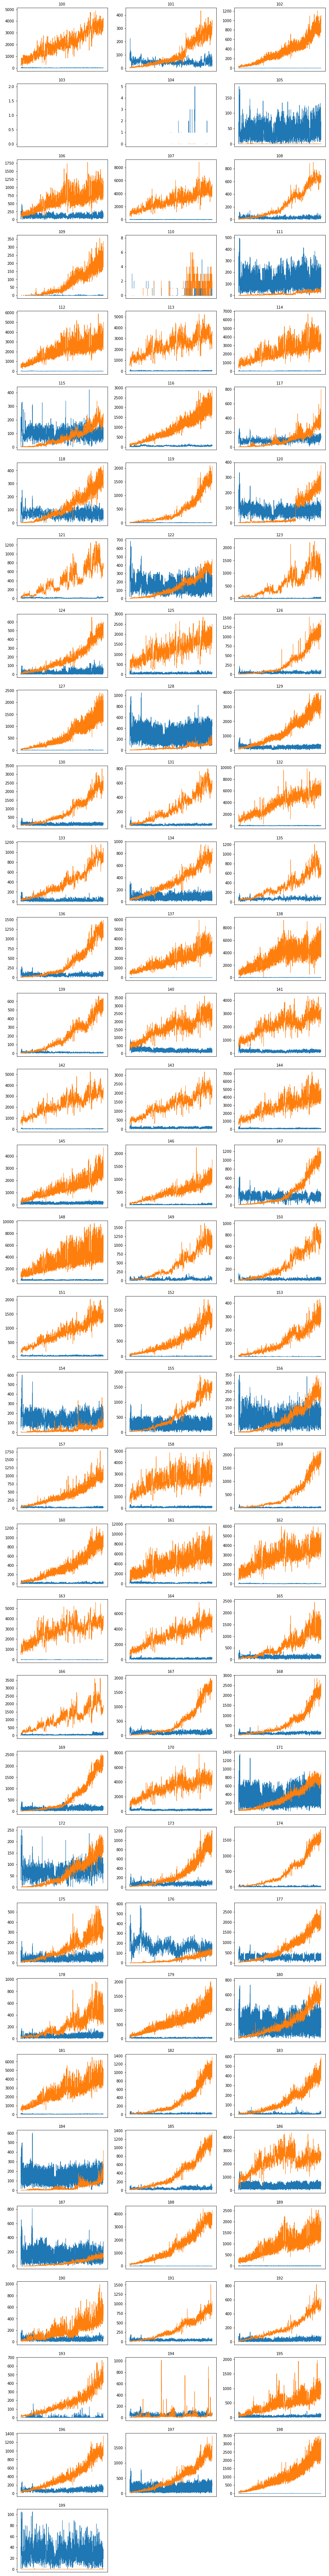

In [66]:
%%time

# Zone 100-199
fig = plt.figure(figsize=(15,200))
num_days = len(dates['date'].unique()) 

for i in range(100,200):
    ax = fig.add_subplot(53,3,i-99)
    temp = pd.merge(dates, df[df['zone']==i][['date', 'pickup', 'tickets']], how='left')
    ax.plot(range(num_days), temp['tickets'], '-', linewidth=1)
    ax.plot(range(num_days), temp['pickup'], '-', linewidth=1)
    ax.set_title(i, fontsize=10)
    ax.set_xticks([])
    #ax.legend()

Wall time: 924 ms


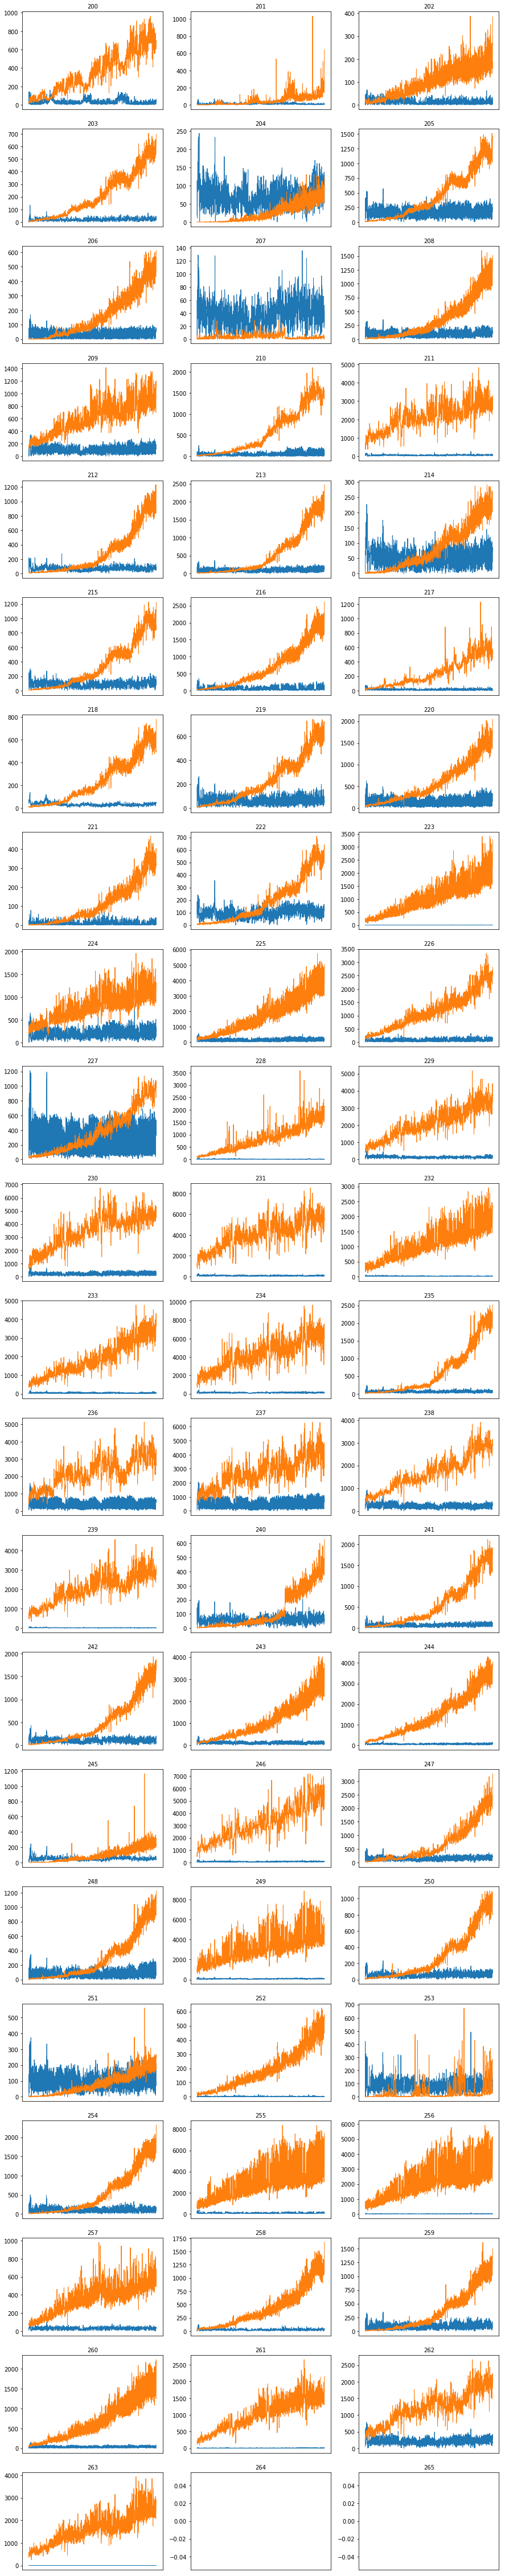

In [67]:
%%time

# Zone 199-265
fig = plt.figure(figsize=(15,200))
num_days = len(dates['date'].unique()) 

for i in range(200,266):
    ax = fig.add_subplot(53,3,i-199)
    temp = pd.merge(dates, df[df['zone']==i][['date', 'pickup', 'tickets']], how='left')
    ax.plot(range(num_days), temp['tickets'], '-', linewidth=1)
    ax.plot(range(num_days), temp['pickup'], '-', linewidth=1)
    ax.set_title(i, fontsize=10)
    ax.set_xticks([])
    #ax.legend()

## correlation clustering

### correlation

In [68]:
corr_list = []
for i in range(1,264):    
    corr = df[df['zone']==i][['pickup', 'tickets']].corr()['tickets'][:1].values[0]
    corr_list.append(corr)
#corr_list

In [69]:
taxi_zones['correlation']=corr_list
taxi_zones.head()

OBJECTID  Shape_Leng  Shape_Area                     zone  LocationID  \
0         1    0.116357    0.000782           Newark Airport           1   
1         2    0.433470    0.004866              Jamaica Bay           2   
2         3    0.084341    0.000314  Allerton/Pelham Gardens           3   
3         4    0.043567    0.000112            Alphabet City           4   
4         5    0.092146    0.000498            Arden Heights           5   

         borough                                           geometry  \
0            EWR  POLYGON ((933100.9183527103 192536.0856972019,...   
1         Queens  (POLYGON ((1033269.243591294 172126.0078125, 1...   
2          Bronx  POLYGON ((1026308.769506663 256767.6975403726,...   
3      Manhattan  POLYGON ((992073.4667968601 203714.0759887695,...   
4  Staten Island  POLYGON ((935843.3104932606 144283.335850656, ...   

   correlation  
0     0.108811  
1    -0.054060  
2    -0.048114  
3    -0.116034  
4     0.113874

Text(0.5, 1.0, 'correlation map')

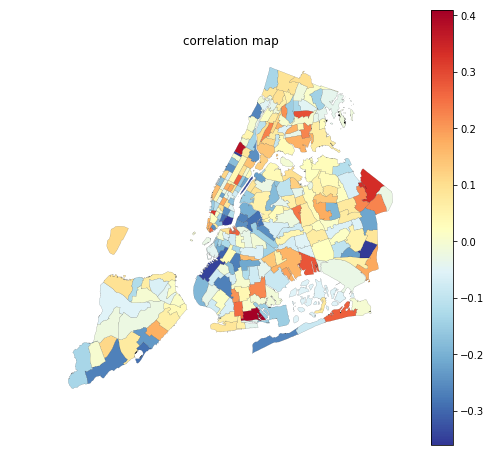

In [70]:
# cmap: https://matplotlib.org/tutorials/colors/colormaps.html
fig, ax = plt.subplots(figsize=(8, 8))
taxi_zones.fillna(0).plot(column = 'correlation', cmap='RdYlBu_r', linewidth=0.1, ax=ax, edgecolor='black', legend=True)
ax.set_axis_off()
plt.title("correlation map")


## Hypothesis test

### pearson

### spearman